In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from modules import inception
tf.__version__

'1.12.0'

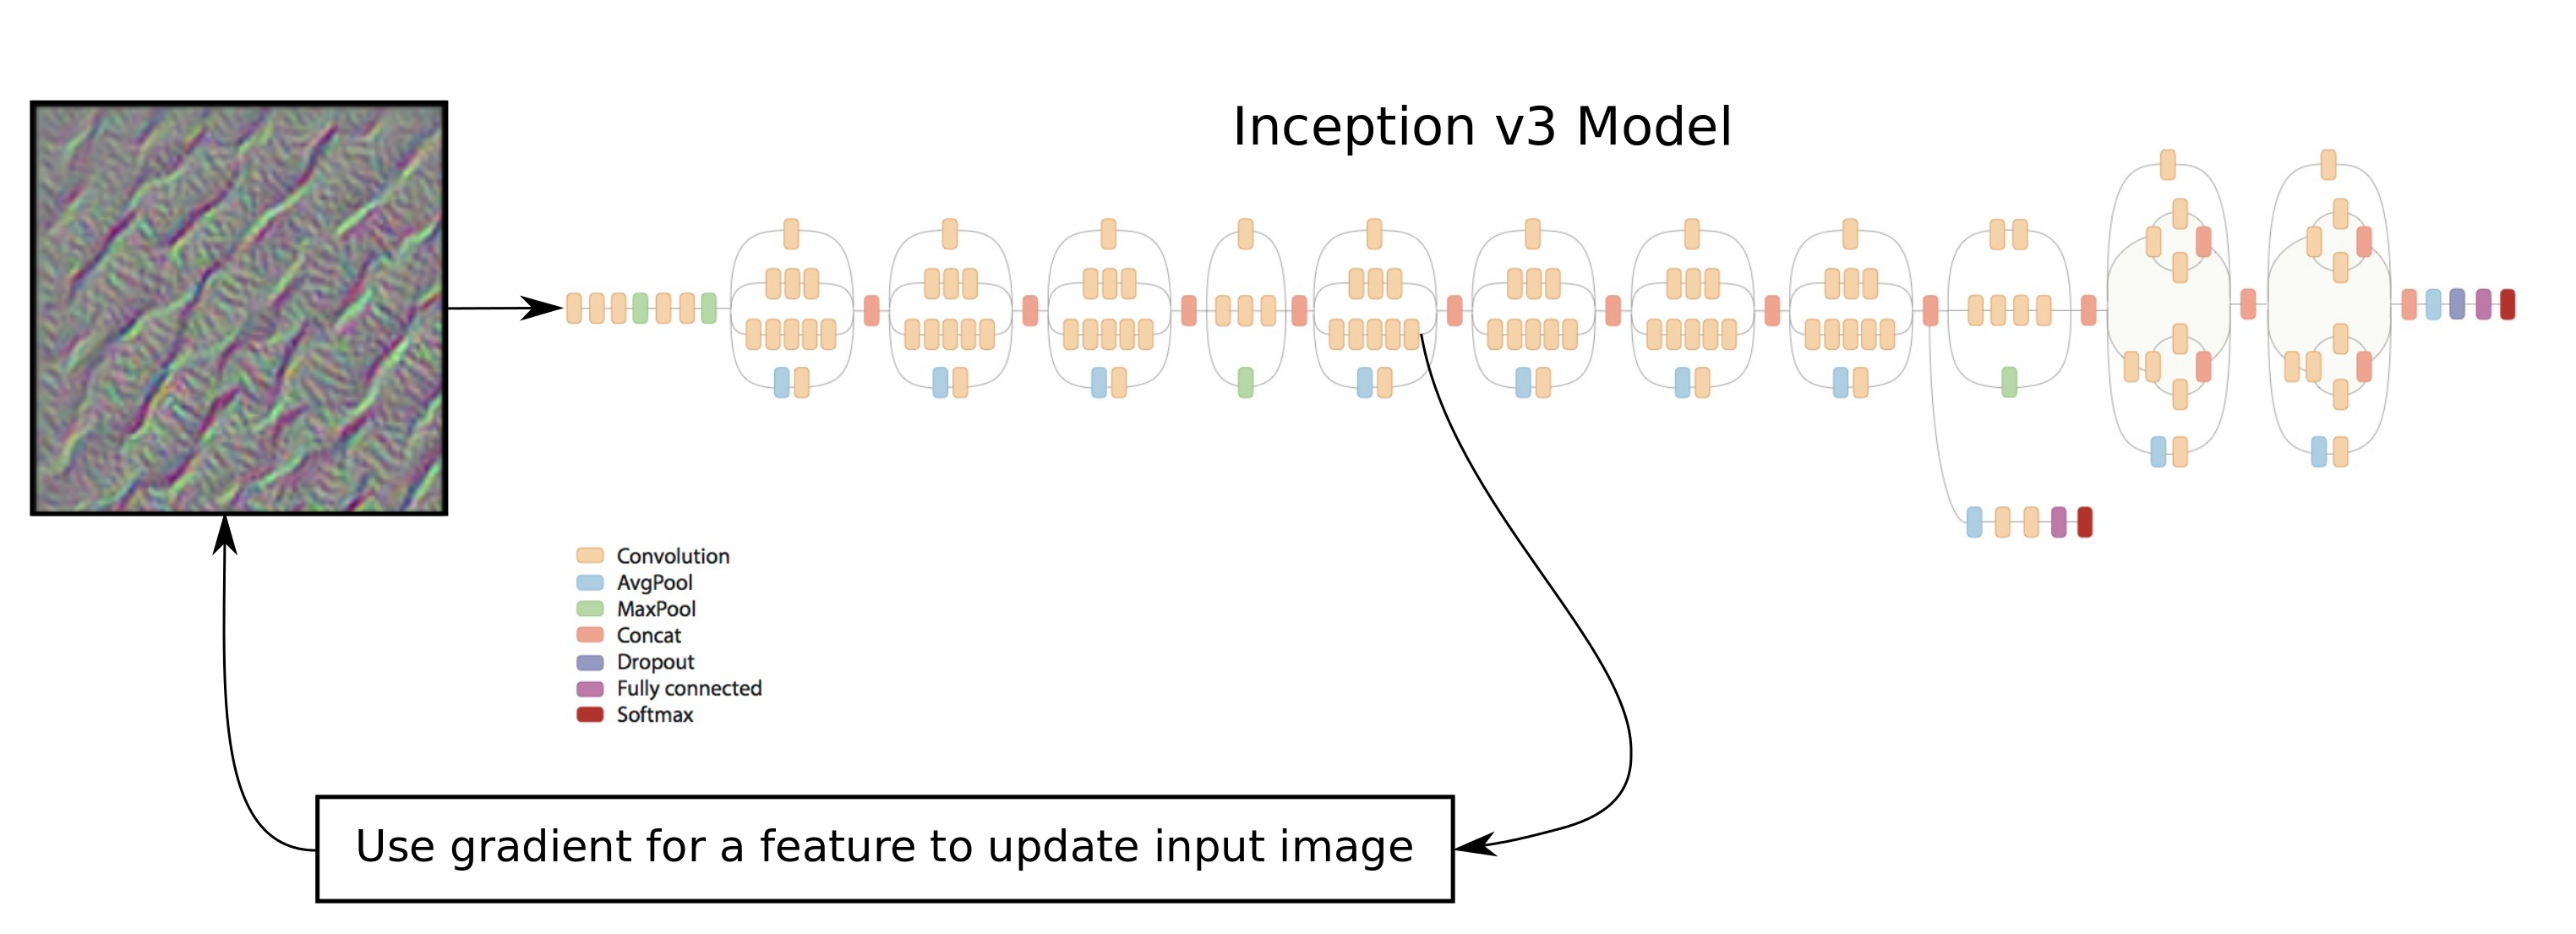

In [2]:
from IPython.display import Image, display
Image('cnn_architecture/inception/visual_analysis_flowchart.png')

In [3]:
# download inception model.
# go to modules directory, execute inception.py
inception.data_dir='cnn_architecture/inception/'
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [4]:
def get_conv_layer_name():
    model = inception.Inception()
    names = [op.name for op in model.graph.get_operations() if op.type == 'Conv2D']
    model.close()
    return names

In [5]:
conv_names = get_conv_layer_name()
print("number of  conv layer:", len(conv_names))
print("1-5 conv layer:\n", conv_names[:5])
print("last 5 conv layer:\n", conv_names[-5:])

number of  conv layer: 94
1-5 conv layer:
 ['conv/Conv2D', 'conv_1/Conv2D', 'conv_2/Conv2D', 'conv_3/Conv2D', 'conv_4/Conv2D']
last 5 conv layer:
 ['mixed_10/tower_1/conv/Conv2D', 'mixed_10/tower_1/conv_1/Conv2D', 'mixed_10/tower_1/mixed/conv/Conv2D', 'mixed_10/tower_1/mixed/conv_1/Conv2D', 'mixed_10/tower_2/conv/Conv2D']


In [6]:
def optimize_image(conv_id=None, feature=0,
                   num_iterations=30, show_progress=True):
    """ 
    find an image that maxmizes the featue
    given by the conv_id and feature number.
    
    parameters:
    conv_id: Integer identifying the covolutional layer to maximize.
    it is an index into conv_names. If None then use the last 
    fully-connected layer before the softmax output.
    feature:
    index into the layer for the feature to maximize.
    num_iteration:
    number of optimization iterations to perform.
    show_progress:
    Boolean whether to show the progress.
    """
    # this done for each call of this function for avoiding
    # computer run out og memory
    model = inception.Inception()
    
    # reference to the tensor that takes the raw input images
    resized_image = model.resized_image
    # referebce to the tensor for the predicted classes
    # This is the output of the final layer's softmax classifier
    y_pred = model.y_pred
    
    # create a loss function that must be maximized
    if conv_id is None:
        # if we want to maximize a feature on the last layer,
        # then we use fully-connected layer prior to the softmax-classifier.
        # the feture no. is the class-number and must be an integer 
        # between 1 and 100. the loss function just the value of that feature.
        loss = model.y_logits[0, feature]
    else:
        # if instead we want to maximize a feature of a convolutional layre
        
        # get the number of convolutional oprator.
        conv_name = conv_names[conv_id]
    
        # get a reference to the tensor that is output by the operator
        # Note that ":0" is added to the name of this.
        tensor = model.graph.get_tensor_by_name(conv_name + ":0")
        
        # set the Inception model's graph as the default 
        # so we can add a operator to it.
        with model.graph.as_default():
            # the loss-function is the average of all the tensor-values
            # for the given feature. This ensure that we generate the 
            # whole input image. you can try and modify this so it use only 
            # a part of the tensor.
            loss = tf.reduce_mean(tensor[:,:,:,feature])
        
    # get the gradient for the loss-function with regard to the resized input image
    # this create a mathematical function for calculating the gardient.
    gradient = tf.gradients(loss, resized_image)
        
    # create a tenflow session, so we can run the graph.
    session = tf.Session(graph=model.graph)
        
    # generate a random image of the same size as the raw input.
    # each pixel is a small random value between 128 and 129,
    # which is about the middle of the color-range(0-256)
    image_shape = resized_image.get_shape()
    image = np.random.uniform(size=image_shape) + 128.0
    
    # performe a number of optimization iteration to find 
    # the image that maximizes the loss function
    for i in range(num_iterations):
        # create a ffed-dict. this fees the image to the tensor 
        # in the graph that holds the resized image, because this 
        # is the final stage for inputting raw image data.
        feed_dict = {model.tensor_name_resized_image: image}
            
        # calculate the predicted class-score, as well as
        # the gradient and the loss value
        pred, grad, loss_value = session.run([y_pred, gradient, loss],
                                                 feed_dict=feed_dict)
        #squeeze the dimensionality for the gradient-array
        grad = np.array(grad).squeeze()
            
        # the gradient now tell us how much we need to change the input image
        # in order to maximize the given feature
            
        # calculating the step-size for updating the image.
        # This step size was found to give fast convergence.
        # the addition of 1e-8 is to protect from div-by-zero
        step_size = 1.0 / (grad.std() + 1e-8)
            
        # update the image by adding the scaled gradient
        # this is called gradient ascent
        image += step_size * grad
            
        # ensure all pixel-value in the image are between 0 and 255.
        image = np.clip(image, 0.0, 255.0)
            
        if show_progress:
            print("Iteration:", i)
                
            # covert the predicted class-score to a one-dim array
            pred = np.squeeze(pred)
                
            # the predicted class for the Inception model 
            pred_cls = np.argmax(pred)
                
            # name of the predicted class.
            cls_name = model.name_lookup.cls_to_name(pred_cls,
                                                         only_first_name=True)
            # the score(probability) for the predicted class.
            cls_score = pred[pred_cls]
                
            # print the predicted score etc.
            msg = "Predicted class name: {0} (#{1}), score;{2:>7.2%}"
            print(msg.format(cls_name, pred_cls, cls_score))
                
            # print the statistics for the gradient.
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, step size: {2:9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))
                
            # print the loss value
            print("Loss:", loss_value)
                
            # Newline.
            print()
    model.close()
    
    return image.squeeze()

In [7]:
# do normalization for image, resize the image pixel value between 0.0 and 1.0
def normalize_image(x):
    # get the min and max value for all pixels in the input
    x_min = x.min()
    x_max = x.max()
    
    # normalization, so all value aer between 0.0 and 1.0
    x_norm = (x - x_min)/(x_max - x_min)
    
    return x_norm

In [8]:
def plo_image(image):
    # normalize the image.
    img_norm = normalize_image(image)
    # plot the image
    plt.imshow(img_norm, interpolation='nearest')
    plt.show()

In [9]:
def plot_images(images, show_size=100):
    """
    The show size is the number of pixels to show for each image.
    the max value is 299.
    """
    # creste figure with sub-plots.
    fig, axes = plt.subplots(2,3)
    # adjusting vertical spacing 
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    # use the interpolation to smooth pixels?
    smooth = True
    
    # interpolation type
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'
        
    # for each entry in the grid
    for i, ax in enumerate(axes.flat):
        # get the i'th image and only use the desired pixels.
        img = images[i, 0:show_size, 0:show_size, :]
        # Normalize the image so its pixels are between 0.0 and 0.1
        img_norm = normalize_image(img)
        # plot the image
        ax.imshow(img_norm, interpolation=interpolation)
        # remove the ticks 
        ax.set_xticks([])
        ax.set_yticks([])
        
    # ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [10]:
# function for optimizing and plotting image
def optimize_images(conv_id=None, num_iterations=30, show_size=100):
    """
    Find 6 images that maximize the 6 first feature in the layer 
    given by the conv_id
    Parameters:
    conv_id: Integer identifying the covolutional layer tomaximize.
    It is an index into conv_names. if none then use the last layer
    before the softmax output.
    num_iterations: number of optimization iterations to perform.
    show_size: number of pixels to show for each image. MAX 299.
    """
    # which layer are we using?
    if conv_id is None:
        print("Final fully-connected layer before softmax")
    else:
        print("Layer:", conv_names[conv_id])
        
    # Initialize the array of images
    images = []
    
    # for each feature do the following. Note that the last fully-connected layer
    # only support numbers between 1 and 1000, while the covolutional layers support
    # numbers between 0 and some other number. so we just use the number 1-7.
    for feature in range(1, 7):
        print("Optimizing image for feature No:", feature)
        # find the image that maximize the given feature
        # for the network layer identified by conv_id(or None).
        image = optimize_image(conv_id=conv_id, feature=feature,
                               show_progress=False,
                               num_iterations=num_iterations)
        
        # squeeze the dim of the array.
        image = image.squeeze()
        
        # append to the list of images.
        images.append(image)
    
    # convert to numpy array, so we can index all dimension easily.
    images = np.array(images)
    
    # plot the image
    plot_images(images=images, show_size=show_size)

Result 
optimize a single image for an early convolutional layer
* As an example, find an image that maximize feature no. 2 of the convolutional layer with the name conv_names [ conv_id ] where conv_id = 5.

In [11]:
image = optimize_image(conv_id=5, feature=2,
                       num_iterations=30, show_progress=True)

Iteration: 0
Predicted class name: dishwasher (#667), score;  5.39%
Gradient min: -0.000090, max:  0.000096, step size:  75888.29
Loss: 4.8388686

Iteration: 1
Predicted class name: kite (#397), score; 14.16%
Gradient min: -0.000107, max:  0.000139, step size:  71868.91
Loss: 5.6017613

Iteration: 2
Predicted class name: syringe (#531), score;  5.06%
Gradient min: -0.000116, max:  0.000111, step size:  80569.35
Loss: 6.9192204

Iteration: 3
Predicted class name: syringe (#531), score;  5.79%
Gradient min: -0.000112, max:  0.000116, step size:  87162.66
Loss: 7.911222

Iteration: 4
Predicted class name: syringe (#531), score;  7.36%
Gradient min: -0.000097, max:  0.000097, step size:  95684.06
Loss: 8.859261

Iteration: 5
Predicted class name: syringe (#531), score; 17.23%
Gradient min: -0.000099, max:  0.000126, step size: 103575.85
Loss: 9.697258

Iteration: 6
Predicted class name: syringe (#531), score; 24.89%
Gradient min: -0.000088, max:  0.000093, step size: 111581.55
Loss: 10.450

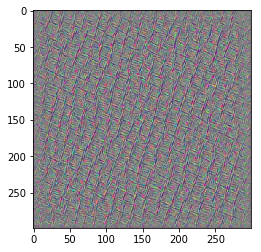

In [12]:
plo_image(image)

optimize multiple images for convolutional layers
* in the following, we optimize and plot multiple images for convolutional layer inside the inception model. These images show what the layers "like to see". Notice that the patterns become incresingly complex for deeper layers.

Layer: conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


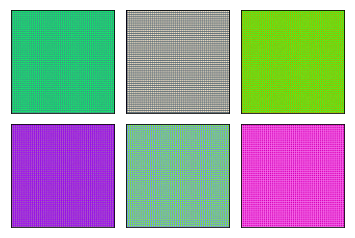

In [13]:
optimize_images(conv_id=0, num_iterations=10)

Layer: conv_1/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


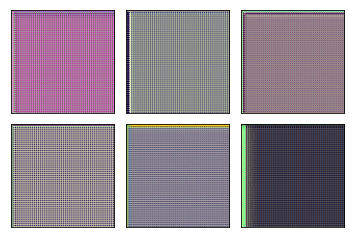

In [14]:
optimize_images(conv_id=1, num_iterations=30)

Layer: conv_2/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


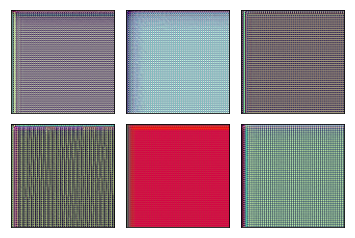

In [15]:
optimize_images(conv_id=2, num_iterations=30)

Layer: conv_3/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


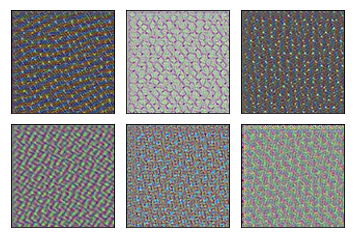

In [16]:
optimize_images(conv_id=3, num_iterations=30)

Layer: conv_4/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


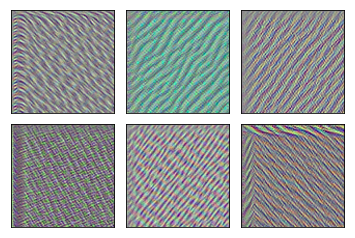

In [17]:
optimize_images(conv_id=4, num_iterations=30)

Layer: mixed/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


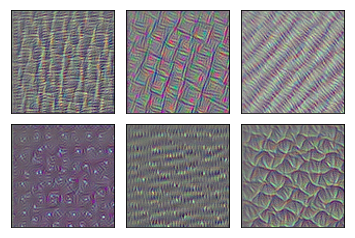

In [18]:
optimize_images(conv_id=5, num_iterations=30)

Layer: mixed/tower/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


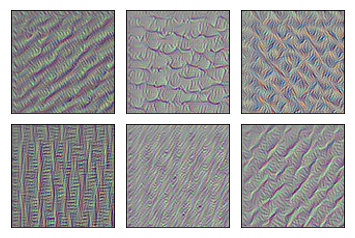

In [19]:
optimize_images(conv_id=6, num_iterations=30)

Layer: mixed/tower/conv_1/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


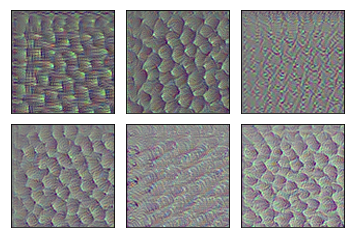

In [20]:
optimize_images(conv_id=7, num_iterations=30)

Layer: mixed/tower_1/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


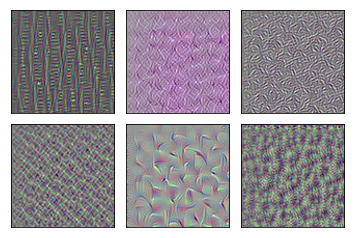

In [21]:
optimize_images(conv_id=8, num_iterations=30)

Layer: mixed/tower_1/conv_1/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


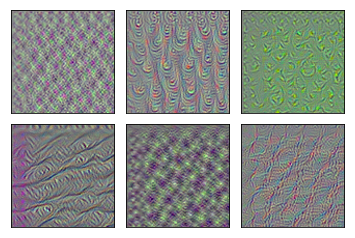

In [22]:
optimize_images(conv_id=9, num_iterations=30)

Layer: mixed/tower_1/conv_2/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


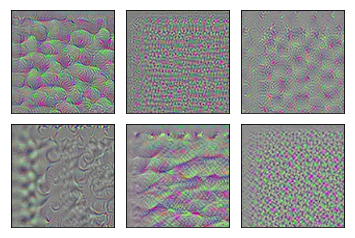

In [23]:
optimize_images(conv_id=10, num_iterations=30)

Layer: mixed_1/tower_1/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


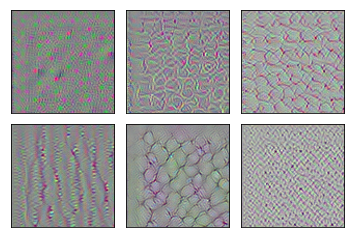

In [24]:
optimize_images(conv_id=15, num_iterations=30)

Layer: mixed_2/tower/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


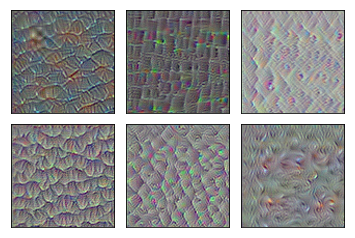

In [25]:
optimize_images(conv_id=20, num_iterations=30)

Layer: mixed_4/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


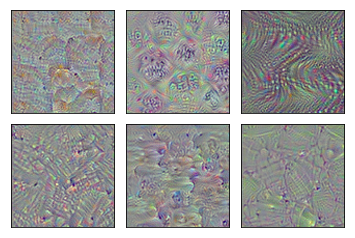

In [26]:
optimize_images(conv_id=30, num_iterations=30)

Layer: mixed_5/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


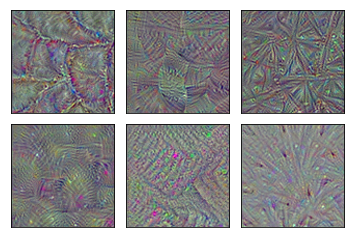

In [27]:
optimize_images(conv_id=40, num_iterations=30)

Layer: mixed_6/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


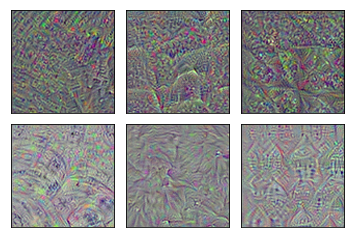

In [28]:
optimize_images(conv_id=50, num_iterations=30)

Layer: mixed_7/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


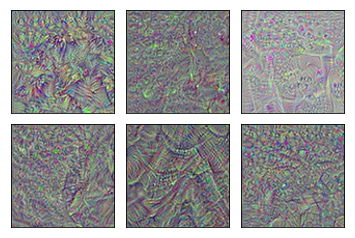

In [29]:
optimize_images(conv_id=60, num_iterations=30)

Layer: mixed_8/tower/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


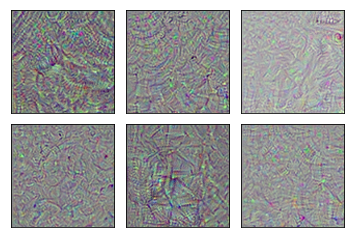

In [30]:
optimize_images(conv_id=70, num_iterations=30)

Layer: mixed_9/tower_1/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


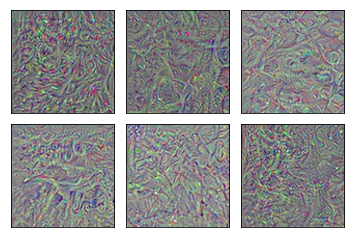

In [31]:
optimize_images(conv_id=80, num_iterations=30)

Layer: mixed_10/tower_1/conv_1/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


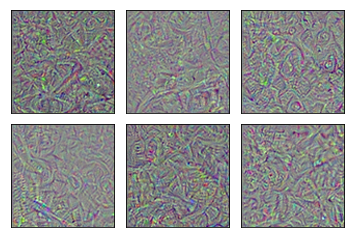

In [32]:
optimize_images(conv_id=90, num_iterations=30)

Layer: mixed_10/tower_2/conv/Conv2D
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


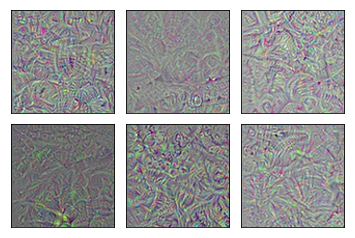

In [33]:
optimize_images(conv_id=93, num_iterations=30)

Final fully-connected layer before softmax
* Now we optimize and plot images for the final layer in the inception model. This is the fully-connected layer right before the softmax classifier. The features in this layer correspond to output classes.
* we might have hoped to see recognizable patterns in these images, e.g. monkeys and birds corresponding to the output classes, but the image just show complex, abstract patterns.

Final fully-connected layer before softmax
Optimizing image for feature No: 1
Optimizing image for feature No: 2
Optimizing image for feature No: 3
Optimizing image for feature No: 4
Optimizing image for feature No: 5
Optimizing image for feature No: 6


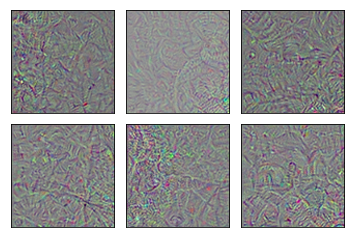

In [34]:
optimize_images(conv_id=None, num_iterations=30)

In [35]:
image = optimize_image(conv_id=None, feature=1, 
                       num_iterations=100, show_progress=True)

Iteration: 0
Predicted class name: dishwasher (#667), score;  5.18%
Gradient min: -0.006604, max:  0.003941, step size:   3935.46
Loss: -0.8550274

Iteration: 1
Predicted class name: dishwasher (#667), score; 15.11%
Gradient min: -0.006044, max:  0.005895, step size:   2319.43
Loss: -1.2258338

Iteration: 2
Predicted class name: spider web (#600), score; 88.13%
Gradient min: -0.005533, max:  0.006257, step size:   2618.18
Loss: 0.48224503

Iteration: 3
Predicted class name: spider web (#600), score; 11.48%
Gradient min: -0.008500, max:  0.007461, step size:   2108.69
Loss: 3.0796711

Iteration: 4
Predicted class name: badger (#16), score;  4.52%
Gradient min: -0.008979, max:  0.010370, step size:   1628.84
Loss: 5.1139197

Iteration: 5
Predicted class name: spider web (#600), score; 15.41%
Gradient min: -0.004716, max:  0.006488, step size:   2372.38
Loss: 4.6685205

Iteration: 6
Predicted class name: wood rabbit (#188), score; 10.72%
Gradient min: -0.008361, max:  0.008055, step size:

Iteration: 59
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.006097, max:  0.006772, step size:   2201.41
Loss: 45.308304

Iteration: 60
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.007019, max:  0.008635, step size:   2363.54
Loss: 43.125534

Iteration: 61
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.009431, max:  0.009069, step size:   1768.23
Loss: 43.920784

Iteration: 62
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.005019, max:  0.006245, step size:   2598.45
Loss: 47.16315

Iteration: 63
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.014429, max:  0.010896, step size:   1669.42
Loss: 47.069595

Iteration: 64
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.004132, max:  0.003836, step size:   2672.93
Loss: 46.615364

Iteration: 65
Predicted class name: kit fox (#1), score;100.00%
Gradient min: -0.006020, max:  0.007157, step size:   2132.65
Loss: 48.638355



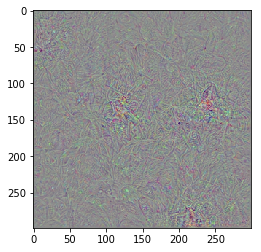

In [36]:
plo_image(image=image)

## Conclusion

This tutorial showed how to optimize input images that maximize features inside a neural network. This allows us to visually analyze what the neural network 'likes to see', because the given feature (or neuron) inside the neural network reacts most strongly to that particular image.

For the lower layers in the neural network, the images had simple patterns, e.g. different types of wavy lines. The image patterns become increasingly complex for deeper layers of the neural network. We might have expected or hoped that the image patterns would be recognizable for deeper layers, e.g. showing monkeys, foxes, cars, etc. But instead the image patterns become increasingly complex and abstract for the deeper layers.

Why is that? Recall from Tutorial #11 that the Inception model can easily be fooled with a little adversarial noise, so it classifies any input image as another target-class. So it is not surprising that the Inception model recognizes these abstract image patterns, which are unclear to the human eye. There is probably an infinite number of images that maximize the features deep inside a neural network, and the images that are also recognizable by humans are only a small fraction of all these image patterns. This may be the reason why the optimization process only found abstract image patterns.

### Other Methods

There are many proposals in the research literature for guiding the optimization process so as to find image patterns that are more recognizable to humans.

[This paper](https://arxiv.org/abs/1506.06579) proposes a combination of heuristics for guiding the optimization process of the image patterns. The paper shows example images for several classes such as flamingo, pelican and black swan, all of which are somewhat recognizable to the human eye. The method is apparently implemented [here](https://github.com/yosinski/deep-visualization-toolbox/blob/master/optimize/gradient_optimizer.py#L313-L346) (the exact line-numbers could change in the future). It requires a combination of heuristics and their parameters must be finely tuned in order to generate these images. But the parameter choice is not entirely clear from the research paper. In spite of several attempts, I could not reproduce their results. Maybe I have misunderstood their paper, or maybe the heuristics were finely tuned to their network architecture, which is a variant of the so-called AlexNet, whereas this tutorial uses the more advanced Inception model.

[This paper](https://arxiv.org/abs/1602.03616) proposes another method for producing images that are even more recognizable to the human eye. However, the method is actually cheating, because it goes through all the images in the training-set (e.g. ImageNet) and takes the images that maximally activate a given feature inside the neural network. Then it clusters and averages similar images. This produces the initial image for the optimization procedure. So it is no wonder that the method gives better results when it starts with an image that is constructed from real photos.
